## Labolatorium 12
### Równania różniczkowe i zagadnienie początkowe

---
### Przydatne importy

In [136]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [14, 7]

---
### Zadanie 1 Metoda Rungego-Kutty

Zaimplementuj metodę Rungego-Kutty czwartego rzędu (rozdział 10.2, Kincaid i Cheney), a następnie:

1. Opisz zalety metody Rungego-Kutty w porównaniu do metody z szeregami Taylora
2. Rozwiąż zagadnienie początkowe dane równaniem $x' = x/t + tsec(x/t)$ z warunkiem początkowym $x(0) = 0$. Przedłuż równanie do $t = 1$ z krokiem $h = 2^{-7}$. Porównaj wynik z dokładnym rozwiązaniem $x(t) = t \cdot arcsin(t)$.
3. Używając tej samej metody rozwiąż zagadnienie początkowe dane równaniem $x' = 100(sin(t) - x)$ z warunkiem początkowym $x(0) = 0$ na przedziale $[0, 3]$ używając kroków o rozmiarach $h = 0.015, 0.02, 0.025, 0.03$. Opisz z czego wynikają różnice w rozwiązaniach.

Implementacja metody *Rungego-Kutty* czwartego rzędu

In [137]:
def rungy_kutty(f, t, x, h, max_iter=10**6):
    t_a = t
    
    for i in range(max_iter):
        K_1 = h * f(t, x)
        K_2 = h * f(t + 0.5 * h, x + 0.5 * K_1)
        K_3 = h * f(t + 0.5 * h, x + 0.5 * K_2)
        K_4 = h * f(t  + h, x + K_3)
        
        x += (K_1 + 2.0 * K_2 + 2.0 * K_3 + K_4) / 6.0
        t = t_a + i * h
    
    return t, x

$$ \large x' = x/t + tsec(x/t) $$

In [138]:
def sec(x):
    return 1.0 / np.cos(x)

def f(t, x):
    eps = 10**(-8)
    return x / t + t * sec(x / t) if abs(t) > eps else 0.0

n = 72
a = 0.0
b = 0.5
h = (b - a) / n
t = a
x = 0.5
rungy_kutty(f, t, x, h, n)

(0.4930555555555555, 521.7642258988283)

Teraz przedłużymy równanie do:
$$ \large x(0) = 0 \\
\large t = 1 \\
\large h = 2^{-7} $$

In [139]:
t = 0.0
x = 0.0
h = 2**(-7)

t, x = rungy_kutty(f, t, x, h, 2**7 + 1)
print(f"t = {t}, x(t) = {x}")

t = 1.0, x(t) = 2.119032825536366


Podczas gdy odkładne rozwiązanie wynosi
$$ \large x(t) = t * arcsin(t) $$

In [140]:
print(f"Dokladne rozwiazanie x(1) = {t * np.arcsin(t)}")

Dokladne rozwiazanie x(1) = 1.5707963267948966


Przedstawmy różnice pomiędzy rozwiązaniami na wykresie

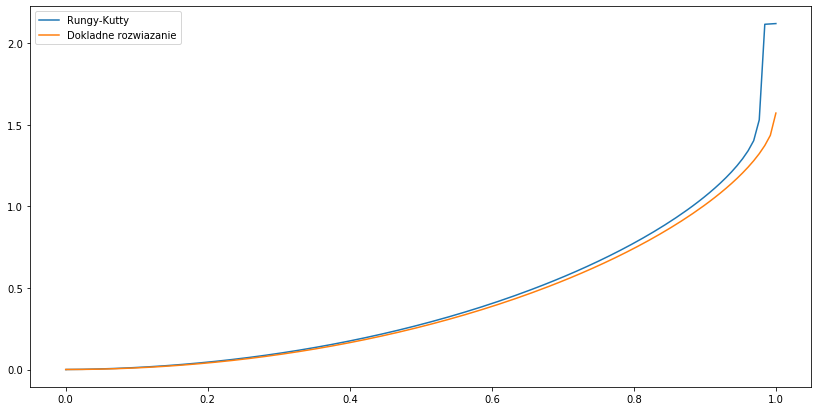

In [141]:
t = 0.0
x = 0.0

appr_solution = np.array([rungy_kutty(f, t, x, h, i) for i in range(2**7 + 2)])
appr_x = appr_solution[:, 1]
T = appr_solution[:, 0]
exac_x = np.array([t * np.arcsin(t) for t in T])


plt.plot(T, appr_x, label="Rungy-Kutty")
plt.plot(T, exac_x, label="Dokladne rozwiazanie")
plt.legend()
plt.show()

Widać, że na całym przedziale różnice są na prawdę **minimalne** lecz wraz ze zwiększeniem odległości od warunku początkowego ($x(0) = 0$) te różnice rosną - tracimy dokładność.

---
Używając tej samej metody rozwiąż zagadnienie początkowe dane równaniem $x'=100(sin(t) − x)$ z warunkiem początkowym $x(0) = 0$ na przedziale $[0, 3]$ używając kroków o rozmiarach $h = 0.015, 0.02, 0.025, 0.03$. Opisz z czego wynikają różnice w rozwiązaniach.

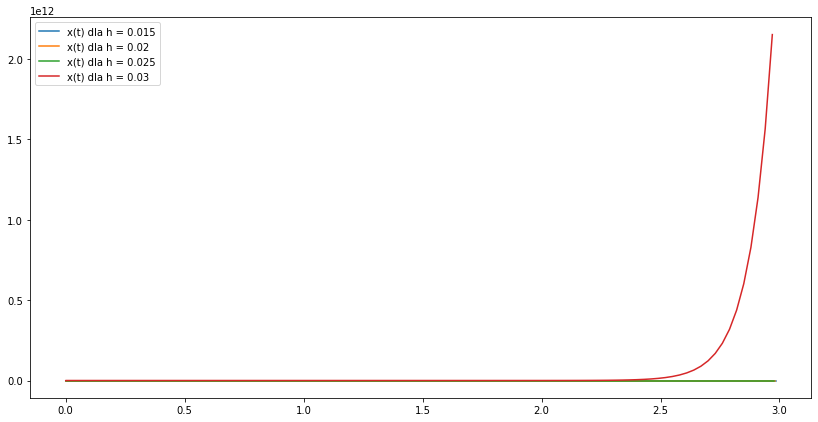

In [143]:
def f(t, x):
    return 100.0 * (np.sin(t) - x)


H = [0.015, 0.02, 0.025, 0.03]

t = 0.0
x = 0.0
a = 0.0
b = 3.0

for h in H:
    n = int((b-a)/h)
    appr_solution = np.array([rungy_kutty(f, t, x, h, i) for i in range(n + 1)])
    appr_x = appr_solution[:, 1]
    T = appr_solution[:, 0]
    plt.plot(T, appr_x, label=f"x(t) dla h = {h}")

plt.legend()
plt.show()

Widać, że dla $h = 0.015, 0.02, 0.025$ wartości x na całym przedziale $[0,3]$ są bardzo podobne i bliskie zeru, natomiast dla $h = 0.03$ i przedziału $[2.5, 3.0]$ wykres znacząco różni się od pozostałych. Może to wynikać z *single-step error* dla źle dobranej długości *stepu*. Można ten problem wyeliminować stosując algorytm **adaptacyjny**, który zostanie pokazany w następnym zadaniu.

#### Wnioski

Algorytm *Rungego-Kutty* jest dosyć dokładną metodą rozwiązywania problemu zagadnienia początkowego. Wymaga on jednak dobrania dobrej długości *stepu* `h`. Algorytm także traci dokładność wraz ze wzrostem odległości od warunku początkowego.

---
### Zadanie 3 Adaptacyjna metoda Rungego-Kutty-Fehlberga

Zaimplementuj adaptacyjną metodę Rungego-Kutty-Fehlberga (rozdział 10.3, Kincaid i Cheney) i użyj jej do rozwiązania zagadnienia początkowego: 
$$
\large x' = 3x/t + 9/2t − 13 \\
\large x(3) = 6 \\
\large t_b = 1/2 \\
$$
z dokładnością do 9 miejsc po przecinku.

Zaczniemy od metody pomocniczej `RK45`, która jest implementacją **fifth-order Runge-Kutta method**.

In [149]:
def RK45(f, t, x, h):
    c20 = 0.25
    c21 = 0.25
    c30 = 0.375
    c31 = 0.09375
    c32 = 0.28125
    c40 = 12.0/13.0
    c41 = 1932.0/2197.0
    c42 = -7200.0/2197.0
    c43 = 7296.0/2197.0
    c51 = 439.0/216.0
    c52 = -8.0
    c53 = 3680.0/513.0
    c54 = -845.0/4104.0
    c60 = 0.5
    c61 = -8.0/27.0
    c62 = 2.0
    c63 = -3544.0/2565.0
    c64 = 1859.0/4104.0
    c65 = -0.275
    a1 = 25.0/216.0
    a3 = 1408.0/2565.0
    a4 = 2197.0/4104.0
    a5 = -0.2
    b1 = 16.0/135.0
    b3 = 6656.0/12825.0
    b4 = 28561.0/56430.0
    b5 = -0.18
    b6 = 2.0/55.0

    K1 = h*f(t,x)
    K2 = h*f(t + c20*h,x + c21*K1)
    K3 = h*f(t + c30*h,x + c31*K1 + c32*K2)
    K4 = h*f(t + c40*h,x + c41*K1 + c42*K2 + c43*K3)
    K5 = h*f(t + h,x + c51*K1 + c52*K2 + c53*K3 + c54*K4)
    K6 = h*f(t + c60*h,x + c61*K1 + c62*K2 + c63*K3 + c64*K4 + c65*K5)
    x4 = x + a1*K1 + a3*K3 + a4*K4 + a5*K5
    x = x + b1*K1 + b3*K3 + b4*K4 + b5*K5 + b6*K6
    t = t + h
    eps = abs(x - x4)
    return t, x, h, eps

Następnie zaimplementuję adaptacyjny algorytm

In [150]:
def RK45_adaptive(f, t, tb, x, h, eps_max, eps_min, h_min, h_max, max_iter=10**5):
    sigma = 0.5 * 10**(-5)
    iflag = 1
    k = 0
    
    while k <= max_iter:
        k += 1
        if abs(h) < h_min:
            h = np.sign(h) * h_min
        
        if abs(h) > h_max:
            h = np.sign(h) * h_max
        
        d = abs(tb - t)
        
        if d <= abs(h):
            iflag = 0
            if d <= sigma * max(abs(tb), abs(t)):
                break
            
            h = np.sign(h) * d
        
        x_save = x
        t_save = t
        
        t, x, h, eps = RK45(f, t, x, h)
        
        if iflag == 0:
            break
        
        if eps < eps_min:
            h *= 2.0
        
        if eps > eps_max:
            h *= 0.5
            x = x_save
            t = t_save
            k -= 1
    
    return t, x, h, iflag  

Teraz postaramy się rozwiązać następujące równanie:
$$
\large x' = 3x/t + 9/2t − 13 \\
\large x(3) = 6 \\
\large t_b = 1/2 \\
$$

In [152]:
def f(t, x):
    eps = 10**(-8)
    return 3.0 * x / t + 4.5 * t - 13.0 if abs(t) > eps else 0.0 

x = 6
t = 3
h_min = 10**(-5)
h_max = 1.0
h = -0.01
eps_min = 10**(-12)
eps_max = 10**(-9)
tb = 0.5

t, x, h, iflag = RK45_adaptive(f, t, tb, x, h, eps_max, eps_min, h_min, h_max)

if iflag:
    print("Przkroczono max limit iteracji")
    
print(f"x({t}) = {x}")

x(0.50000000000002) = 2.2500000002065494


Porównaj wynik z rozwiązaniem analitycznym $x = t^3 − 9/2t^2 + 13/2t$. W jaki sposób metoda adaptacyjna pozwala nam zwiększyć dokładność rozwiązania? Jakie są tego wady?

In [158]:
def solution(t):
    return t**3 - 4.5 * t**2 + 6.5 * t

print(f"x(0.5) = {solution(t)}")
print(f"Roznica pomiedzy naszym rozwiazanie a analitycznym:\n{abs(solution(t)-x)}")

x(0.5) = 2.2500000000000546
Roznica pomiedzy naszym rozwiazanie a analitycznym:
2.0649482124213137e-10


Jak widać, udało nam się uzyskać zadaną dokładność. Różnica pomiędzy rozwiązaniem analitycznym, a przybliżonym metodą adaptacyjną jest rzędu $10^{-10}$. Co więcej, cały algorytm wykonał się dość szybko. Wymagało to jednak odpowiedniego doboru argumentów początkowych

**Metoda adaptacyjna** zwiększa dokładność rozwiązania poprzez korekcję długości *stepu* `h` podczas iterowania. Pozwala dobrać długość stepu w taki sposób, aby uzyskać zadaną dokładność (o ile to możliwe).

#### Wady metody adaptacyjnej:
* Wymaga podania większej ilości argumentów i ich doboru zależy czy otrzymamy oczekiwany wynik
* Wykonuje dużo więcej operacji arytmetycznych - zwiększa się czas działania algorytmu
* Nie zawsze potrafi dotrzeć do oczekiwanej dokładności - algorytm kończy się po wykonaniu maksymalnej liczby iteracji

#### Wnioski

Metoda adaptacyjna potrafi znaleźć rozwiązanie z zadaną przez nas dokładnością. W naszym zadaniu udało nam się znaleźć rozwiązanie z dokładnością $10^(-9)$ - jest to bardzo dobry wynik. Ma jednak ona swoje wady, o których należy pamiętać przy jej używaniu.